In [11]:

import yfinance as yf
import numpy as np
import pandas as pd

def fetch_stock_data(stock_tickers, start_date, end_date):
    """
    Fetch historical adjusted close price data for a list of stock tickers over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to fetch data for.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.

    Returns:
    - list of dict: A list of dictionaries where each dictionary represents a row of stock data with date and adjusted close prices.
    """
    stock_data = {}
    for ticker in stock_tickers:
        # Fetch adjusted close prices for each ticker
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    
    # Convert the stock data into a DataFrame
    df = pd.DataFrame(stock_data)
    df.index = df.index.strftime('%Y-%m-%d')  # Convert index (dates) to string format
    df = df.reset_index()  # Flatten the index into a column
    return df.to_dict(orient='records')  # Convert DataFrame to a list of dictionaries


def calculate_beta(stock_tickers, market_ticker, start_date, end_date):
    """
    Calculate Beta for each stock relative to a market index.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate Beta for.
    - market_ticker (str): The ticker symbol of the market index (benchmark).
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (Beta values).
    """
    # Fetch data for stocks and market index
    stock_data = fetch_stock_data(stock_tickers + [market_ticker], start_date, end_date)
    returns = pd.DataFrame(stock_data).pct_change().dropna()  # Calculate returns and drop missing values
    market_returns = returns[market_ticker]

    betas = {}
    for ticker in stock_tickers:
        # Compute covariance matrix between stock returns and market returns
        cov_matrix = np.cov(returns[ticker], market_returns)
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]  # Beta calculation
        betas[ticker] = {
            'x': returns.index,  # Time (dates)
            'y': beta  # Beta value
        }
    return betas

def calculate_alpha(stock_tickers, benchmark_returns, start_date, end_date, risk_free_rate=0.01):
    """
    Calculate Alpha for each stock compared to a benchmark index.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate Alpha for.
    - benchmark_returns (pd.Series): Series of benchmark returns.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.
    - risk_free_rate (float): The risk-free rate for calculating excess returns (default is 0.01).

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (Alpha values).
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = pd.DataFrame(stock_data).pct_change().dropna()
    
    alphas = {}
    for ticker in stock_tickers:
        stock_return = returns[ticker].mean() * 252  # Annualized stock return
        benchmark_return = benchmark_returns.mean() * 252  # Annualized benchmark return
        beta = calculate_beta([ticker], benchmark_returns.name, start_date, end_date)[ticker]['y']
        alpha = stock_return - (risk_free_rate + beta * (benchmark_return - risk_free_rate))  # Alpha calculation
        alphas[ticker] = {
            'x': returns.index,
            'y': alpha
        }
    return alphas

def calculate_drawdown(stock_tickers, start_date, end_date):
    """
    Calculate drawdown for each stock over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate drawdown for.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (drawdown values).
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    drawdowns = {}

    for ticker in stock_tickers:
        # Calculate cumulative returns and drawdown
        cumulative_return = stock_data[ticker] / stock_data[ticker].cummax() - 1
        drawdowns[ticker] = {
            'x': stock_data.index,
            'y': cumulative_return
        }
    return drawdowns

def calculate_cumulative_return(stock_tickers, start_date, end_date):
    """
    Calculate cumulative return for each stock over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate cumulative return for.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (cumulative return values).
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    cumulative_returns = {}

    for ticker in stock_tickers:
        # Calculate cumulative return from initial value
        cumulative_returns[ticker] = {
            'x': stock_data.index,
            'y': (stock_data[ticker] / stock_data[ticker].iloc[0]) - 1
        }
    return cumulative_returns

def calculate_sortino_ratio(stock_tickers, start_date, end_date, risk_free_rate=0.01):
    """
    Calculate Sortino Ratio for each stock over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate Sortino Ratio for.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.
    - risk_free_rate (float): The risk-free rate for calculating excess returns (default is 0.01).

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (Sortino Ratio values).
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = pd.DataFrame(stock_data).pct_change().dropna()

    sortino_ratios = {}
    for ticker in stock_tickers:
        # Calculate downside deviation for negative returns
        negative_returns = returns[returns[ticker] < 0][ticker]
        downside_deviation = negative_returns.std() * np.sqrt(252)
        excess_return = returns[ticker].mean() * 252 - risk_free_rate  # Excess return over risk-free rate
        sortino_ratios[ticker] = {
            'x': returns.index,
            'y': excess_return / downside_deviation  # Sortino Ratio calculation
        }
    return sortino_ratios

def calculate_correlation_with_market(stock_tickers, market_ticker, start_date, end_date):
    """
    Calculate the correlation between each stock and the market index over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate correlation for.
    - market_ticker (str): The ticker symbol of the market index (benchmark).
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (correlation values).
    """
    stock_data = fetch_stock_data(stock_tickers + [market_ticker], start_date, end_date)
    returns = pd.DataFrame(stock_data).pct_change().dropna()
    market_returns = returns[market_ticker]

    correlations = {}
    for ticker in stock_tickers:
        # Calculate rolling correlation with the market index
        correlation = returns[ticker].rolling(window=21).corr(market_returns)
        correlations[ticker] = {
            'x': returns.index,
            'y': correlation
        }
    return correlations

def calculate_sharpe_ratio(stock_tickers, start_date, end_date, risk_free_rate=0.01):
    """
    Calculate Sharpe Ratio for each stock over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate Sharpe Ratio for.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.
    - risk_free_rate (float): The risk-free rate for calculating excess returns (default is 0.01).

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (Sharpe Ratio values).
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = pd.DataFrame(stock_data).pct_change().dropna()

    # Sharpe Ratio = (Mean Return - Risk Free Rate) / Std Dev of Returns
    sharpe_ratios = {}
    for ticker in stock_tickers:
        excess_returns = returns[ticker] - (risk_free_rate / 252)  # Adjust returns by risk-free rate
        sharpe_ratios[ticker] = {
            'x': returns.index,  # Time (dates)
            'y': (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)  # Sharpe Ratio calculation
        }
    return sharpe_ratios

def calculate_volatility(stock_tickers, start_date, end_date):
    """
    Calculate the volatility for each stock over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate volatility for.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (volatility values).
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = pd.DataFrame(stock_data).pct_change().dropna()

    volatilities = {}
    for ticker in stock_tickers:
        # Calculate 21-day rolling volatility and annualize it
        volatilities[ticker] = {
            'x': returns.index,  # Time (dates)
            'y': returns[ticker].rolling(window=21).std() * np.sqrt(252)  # Volatility calculation
        }
    return volatilities

def calculate_value_at_risk(stock_tickers, start_date, end_date, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) for each stock over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to calculate VaR for.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.
    - confidence_level (float): Confidence level for VaR calculation (default is 0.95).

    Returns:
    - dict: A dictionary where the keys are stock tickers and the values are dictionaries with 'x' (dates) and 'y' (VaR values).
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = pd.DataFrame(stock_data).pct_change().dropna()

    vars = {}
    for ticker in stock_tickers:
        # Calculate rolling VaR with a 21-day window
        vars[ticker] = {
            'x': returns.index,  # Time (dates)
            'y': returns[ticker].rolling(window=21).apply(
                lambda x: np.percentile(x, (1 - confidence_level) * 100), raw=True
            )  # VaR calculation
        }
    return vars

def calculate_efficient_frontier(stock_tickers, start_date, end_date):
    """
    Calculate the Efficient Frontier for a set of stocks over a specified date range.

    Parameters:
    - stock_tickers (list of str): List of stock tickers to include in the efficient frontier calculation.
    - start_date (str): The start date for the data retrieval in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data retrieval in 'YYYY-MM-DD' format.

    Returns:
    - dict: A dictionary with 'x' (volatility values) and 'y' (return values) for the efficient frontier.
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = pd.DataFrame(stock_data).pct_change().dropna()

    mean_returns = returns.mean() * 252  # Annualized returns
    cov_matrix = returns.cov() * 252     # Annualized covariance matrixS

    # Simulate random portfolios to estimate the efficient frontierS
    num_portfolios = 10000
    results = np.zeros((3, num_portfolios))  # 3 rows: volatility, return, Sharpe ratio
    for i in range(num_portfolios):
        weights = np.random.random(len(stock_tickers))
        weights /= np.sum(weights)  # Normalize weights to sum to 1
        
        portfolio_return = np.dot(weights, mean_returns)  # Portfolio return
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio volatility

        results[0, i] = portfolio_volatility  # Volatility
        results[1, i] = portfolio_return  # Return
        results[2, i] = results[1, i] / results[0, i]  # Sharpe Ratio

    return {
        'x': results[0],  # Volatility (Risk)
        'y': results[1]   # Return (Reward)
    }

In [12]:
# Test the functions

start_date = '2023-01-01'
end_date = '2024-01-01'
stock_tickers = ['AAPL', 'MSFT', 'GOOGL']
market_ticker = 'SPY'

# Fetch stock data
print("Fetching stock data...")
stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
print("Stock Data:", stock_data[:5])  # Print first 5 records for brevity

# Calculate Beta
print("\nCalculating Beta...")
betas = calculate_beta(stock_tickers, market_ticker, start_date, end_date)
print("Betas:", betas)

# Calculate Alpha (benchmark returns as a Series for demonstration)
benchmark_data = fetch_stock_data([market_ticker], start_date, end_date)
benchmark_returns = pd.Series(pd.DataFrame(benchmark_data).pct_change().dropna()[market_ticker])
print("\nCalculating Alpha...")
alphas = calculate_alpha(stock_tickers, benchmark_returns, start_date, end_date)
print("Alphas:", alphas)

# Calculate Drawdown
print("\nCalculating Drawdown...")
drawdowns = calculate_drawdown(stock_tickers, start_date, end_date)
print("Drawdowns:", drawdowns)

# Calculate Cumulative Return
print("\nCalculating Cumulative Return...")
cumulative_returns = calculate_cumulative_return(stock_tickers, start_date, end_date)
print("Cumulative Returns:", cumulative_returns)

# Calculate Sortino Ratio
print("\nCalculating Sortino Ratio...")
sortino_ratios = calculate_sortino_ratio(stock_tickers, start_date, end_date)
print("Sortino Ratios:", sortino_ratios)

# Calculate Correlation with Market
print("\nCalculating Correlation with Market...")
correlations = calculate_correlation_with_market(stock_tickers, market_ticker, start_date, end_date)
print("Correlations:", correlations)

# Calculate Sharpe Ratio
print("\nCalculating Sharpe Ratio...")
sharpe_ratios = calculate_sharpe_ratio(stock_tickers, start_date, end_date)
print("Sharpe Ratios:", sharpe_ratios)

# Calculate Volatility
print("\nCalculating Volatility...")
volatilities = calculate_volatility(stock_tickers, start_date, end_date)
print("Volatilities:", volatilities)

# Calculate Value at Risk
print("\nCalculating Value at Risk...")
vars = calculate_value_at_risk(stock_tickers, start_date, end_date)
print("Value at Risk:", vars)

# Calculate Efficient Frontier
print("\nCalculating Efficient Frontier...")
efficient_frontier = calculate_efficient_frontier(stock_tickers, start_date, end_date)
print("Efficient Frontier:", efficient_frontier)

Fetching stock data...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Stock Data: [{'Date': '2023-01-03', 'AAPL': 123.90463256835938, 'MSFT': 236.1835174560547, 'GOOGL': 88.89987182617188}, {'Date': '2023-01-04', 'AAPL': 125.18260955810547, 'MSFT': 225.8520965576172, 'GOOGL': 87.86243438720703}, {'Date': '2023-01-05', 'AAPL': 123.85509490966797, 'MSFT': 219.1583709716797, 'GOOGL': 85.9870834350586}, {'Date': '2023-01-06', 'AAPL': 128.4122314453125, 'MSFT': 221.74119567871094, 'GOOGL': 87.12425994873047}, {'Date': '2023-01-09', 'AAPL': 128.9373016357422, 'MSFT': 223.90016174316406, 'GOOGL': 87.80258178710938}]

Calculating Beta...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 compl

TypeError: unsupported operand type(s) for /: 'str' and 'str'

Fetching stock data...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Calculating Beta...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<class 'dict'>
Betas: {'AAPL': 1.103662775445219, 'GOOGL': 1.3831945508980945, 'MSFT': 1.1722433334836415}
[*********************100%%**********************]  1 of 1 completed

Calculating Alpha...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

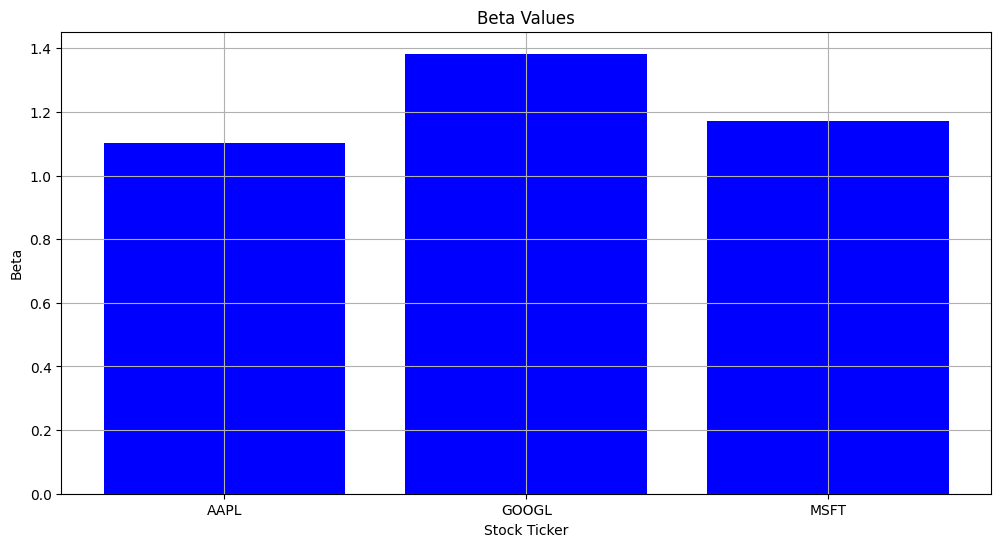

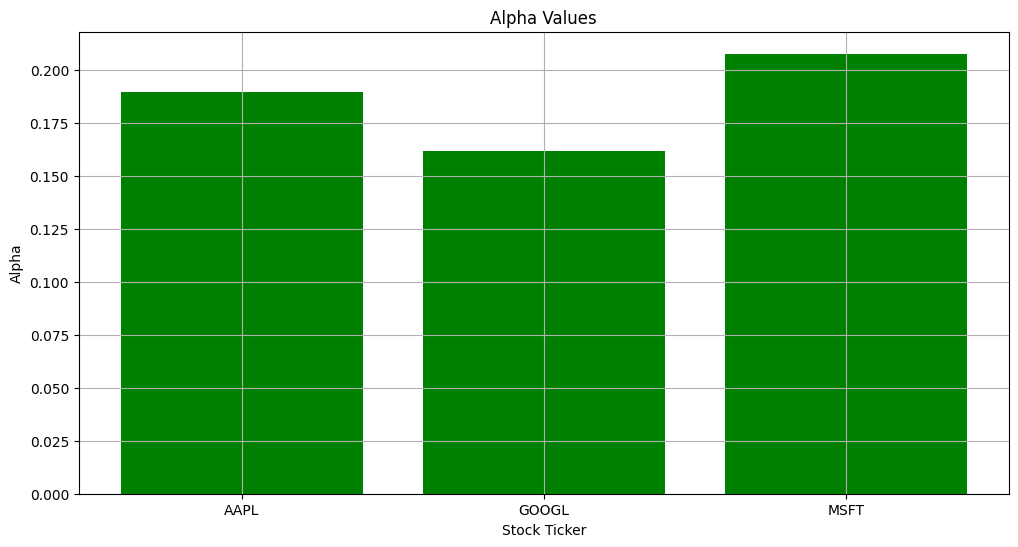

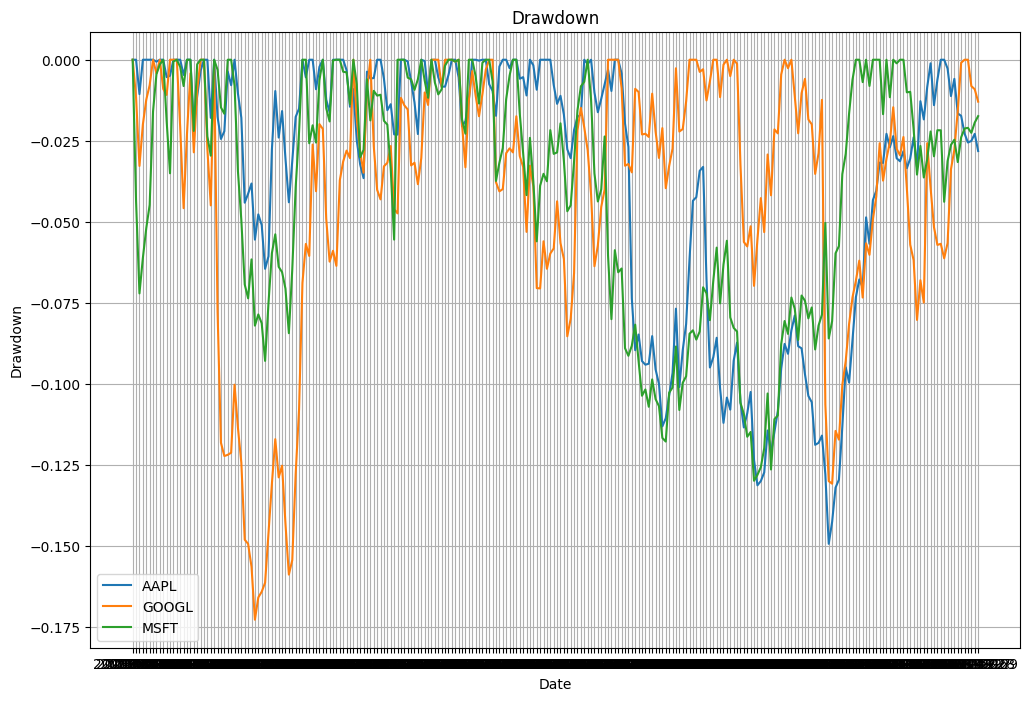

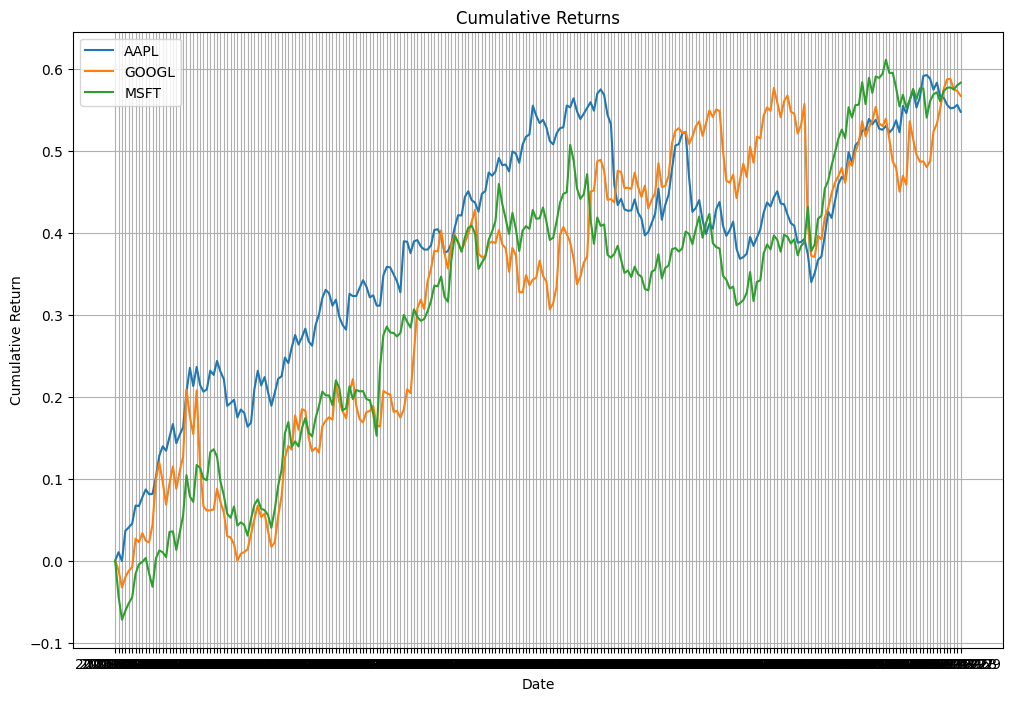

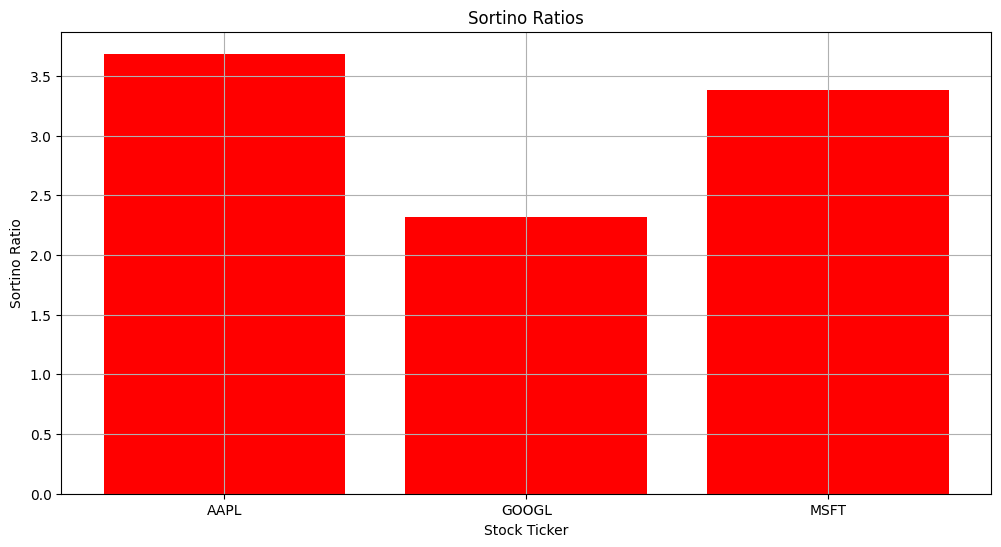

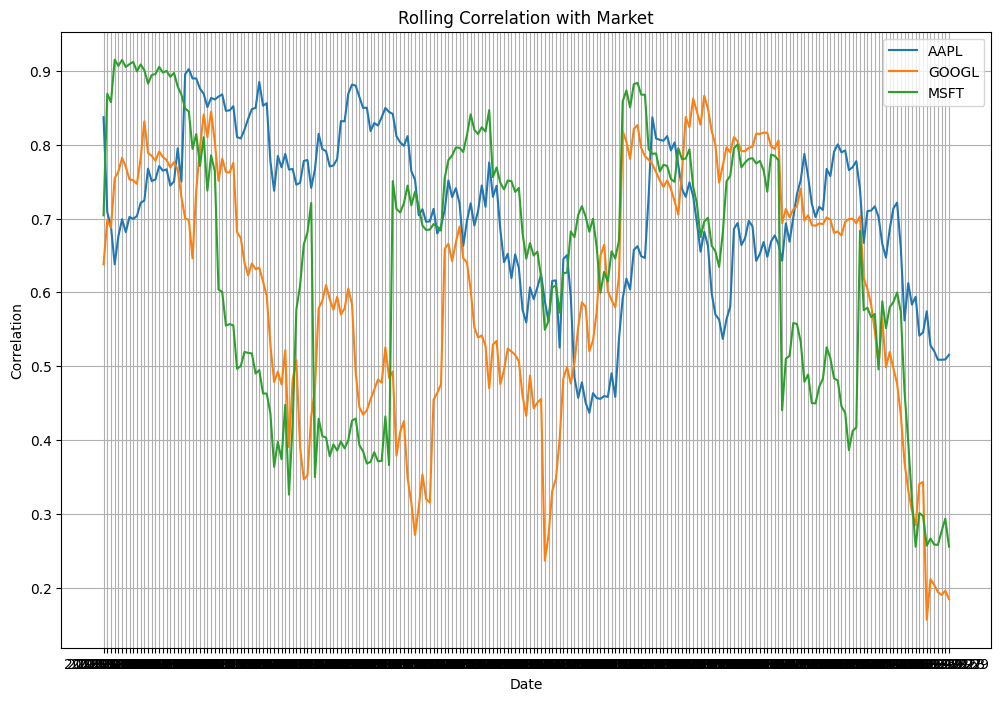

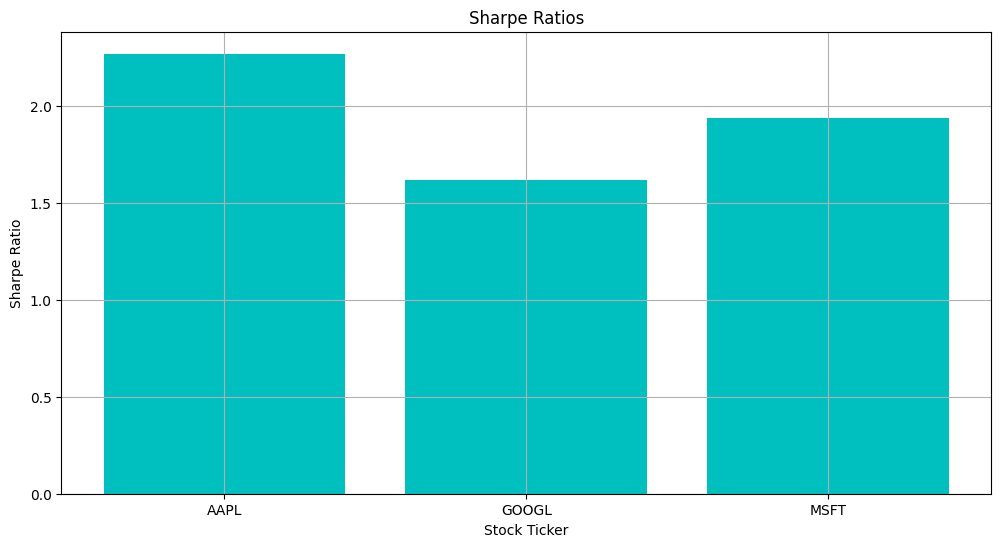

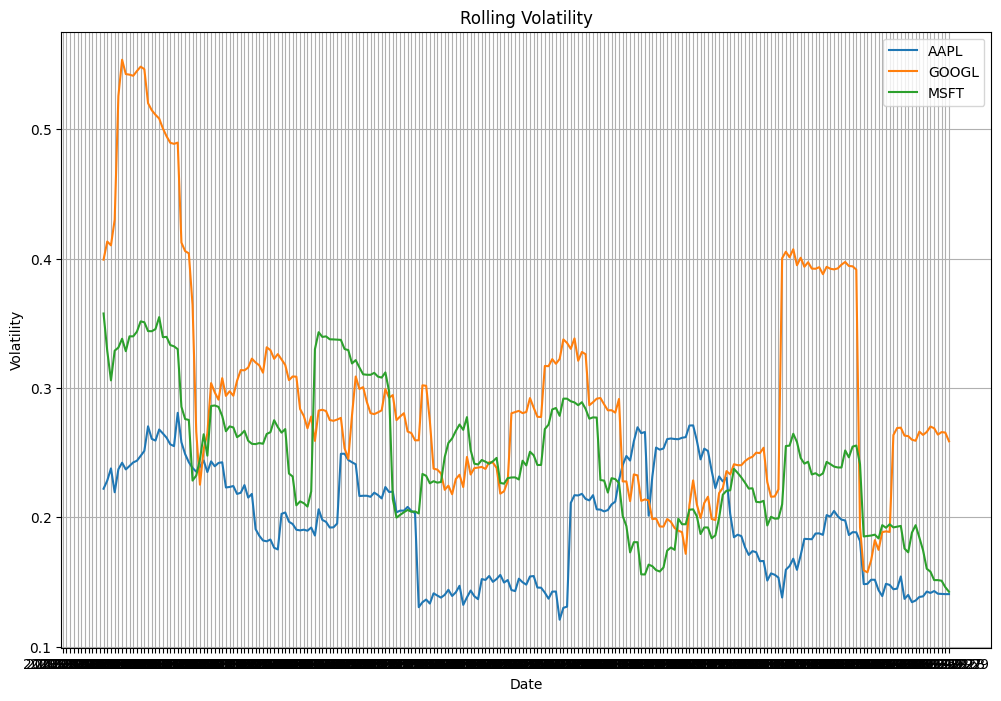

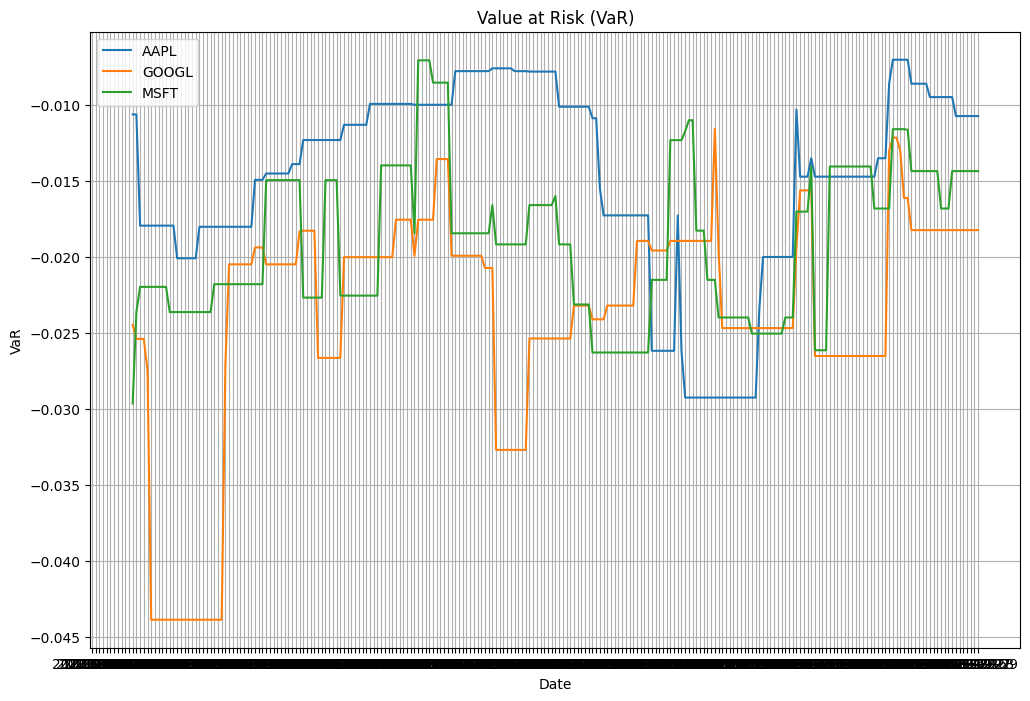

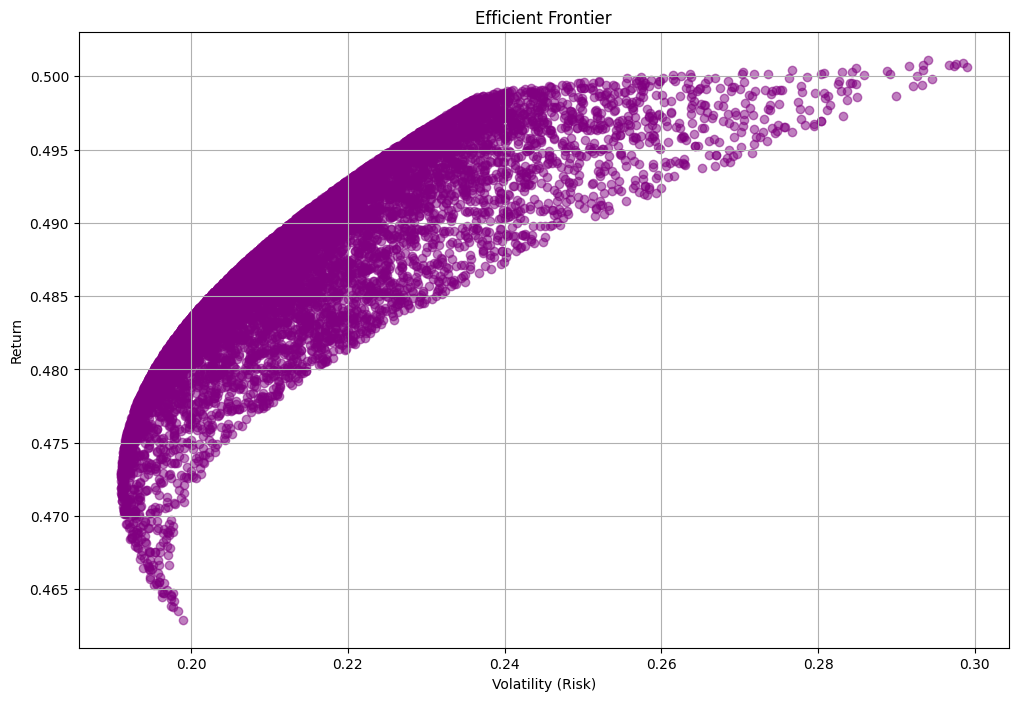

In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Define your functions

def fetch_stock_data(stock_tickers, start_date, end_date):
    stock_data = {}
    for ticker in stock_tickers:
        df = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
        stock_data[ticker] = df
    df = pd.DataFrame(stock_data)
    df.index = df.index.strftime('%Y-%m-%d')
    return df

def calculate_beta(stock_tickers, market_ticker, start_date, end_date):
    stock_data = fetch_stock_data(stock_tickers + [market_ticker], start_date, end_date)
    returns = stock_data.pct_change().dropna()
    market_returns = returns[market_ticker]
    betas = {}
    for ticker in stock_tickers:
        cov_matrix = np.cov(returns[ticker], market_returns)
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
        betas[ticker] = beta
    
    print(type (betas))
    return betas

def calculate_alpha(stock_tickers, benchmark_returns, start_date, end_date, risk_free_rate=0.01):
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = stock_data.pct_change().dropna()
    alphas = {}
    for ticker in stock_tickers:
        stock_return = returns[ticker].mean() * 252
        benchmark_return = benchmark_returns.mean() * 252
        beta = calculate_beta([ticker], benchmark_returns.name, start_date, end_date)[ticker]
        alpha = stock_return - (risk_free_rate + beta * (benchmark_return - risk_free_rate))
        alphas[ticker] = alpha
    return alphas

def calculate_drawdown(stock_tickers, start_date, end_date):
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    drawdowns = {}
    df = stock_data.pct_change().dropna()
    for ticker in stock_tickers:
        cumulative_return = (stock_data[ticker] / stock_data[ticker].cummax() - 1).dropna()
        drawdowns[ticker] = cumulative_return
    
    print(type (betas))
    return drawdowns

def calculate_cumulative_return(stock_tickers, start_date, end_date):
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    cumulative_returns = {}
    for ticker in stock_tickers:
        cumulative_return = (stock_data[ticker] / stock_data[ticker].iloc[0]) - 1
        cumulative_returns[ticker] = cumulative_return
    return cumulative_returns

def calculate_sortino_ratio(stock_tickers, start_date, end_date, risk_free_rate=0.01):
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = stock_data.pct_change().dropna()
    sortino_ratios = {}
    for ticker in stock_tickers:
        negative_returns = returns[returns[ticker] < 0][ticker]
        downside_deviation = negative_returns.std() * np.sqrt(252)
        excess_return = returns[ticker].mean() * 252 - risk_free_rate
        sortino_ratios[ticker] = excess_return / downside_deviation
    return sortino_ratios

def calculate_correlation_with_market(stock_tickers, market_ticker, start_date, end_date):
    stock_data = fetch_stock_data(stock_tickers + [market_ticker], start_date, end_date)
    returns = stock_data.pct_change().dropna()
    market_returns = returns[market_ticker]
    correlations = {}
    for ticker in stock_tickers:
        correlation = returns[ticker].rolling(window=21).corr(market_returns).dropna()
        correlations[ticker] = correlation
    return correlations

def calculate_sharpe_ratio(stock_tickers, start_date, end_date, risk_free_rate=0.01):
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = stock_data.pct_change().dropna()
    sharpe_ratios = {}
    for ticker in stock_tickers:
        excess_returns = returns[ticker] - (risk_free_rate / 252)
        sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
        sharpe_ratios[ticker] = sharpe_ratio
    return sharpe_ratios

def calculate_volatility(stock_tickers, start_date, end_date):
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = stock_data.pct_change().dropna()
    volatilities = {}
    for ticker in stock_tickers:
        volatility = returns[ticker].rolling(window=21).std() * np.sqrt(252)
        volatilities[ticker] = volatility
    return volatilities

def calculate_value_at_risk(stock_tickers, start_date, end_date, confidence_level=0.95):
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = stock_data.pct_change().dropna()
    vars = {}
    for ticker in stock_tickers:
        var = returns[ticker].rolling(window=21).apply(lambda x: np.percentile(x, (1 - confidence_level) * 100))
        vars[ticker] = var
    return vars

# Function to calculate the Efficient Frontier
def calculate_efficient_frontier(stock_tickers, start_date, end_date):
    """
    Calculates the Efficient Frontier for a given set of stocks. The Efficient Frontier shows the best possible return
    for a given level of risk, or the lowest risk for a given return.

    Parameters:
    - stock_tickers (list): List of stock tickers to calculate the Efficient Frontier for.
    - start_date (str): Start date for fetching the stock data (format: 'YYYY-MM-DD').
    - end_date (str): End date for fetching the stock data (format: 'YYYY-MM-DD').

    Returns:
    - dict: Dictionary containing lists of portfolio returns, risks, and Sharpe ratios.
    """
    stock_data = fetch_stock_data(stock_tickers, start_date, end_date)
    returns = stock_data.pct_change().dropna()
    mean_returns = returns.mean() * 252  # Annualized mean returns
    cov_matrix = returns.cov() * 252  # Annualized covariance matrix

    num_portfolios = 10000
    results = np.zeros((3, num_portfolios))
    
    for i in range(num_portfolios):
        weights = np.random.random(len(stock_tickers))
        weights /= np.sum(weights)
        
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_stddev
        results[2, i] = results[0, i] / results[1, i]  # Sharpe ratio
    
    # Convert numpy arrays to lists for JSON serialization
    efficient_frontier = {
        'returns': results[0].tolist(),
        'risks': results[1].tolist(),
        'sharpe_ratios': results[2].tolist()
    }
    
    return efficient_frontier

start_date = '2023-01-01'
end_date = '2024-01-01'
stock_tickers = ['AAPL', 'GOOGL', 'MSFT']
market_ticker = 'SPY'
risk_free_rate = 0.01

# Fetch stock data
print("Fetching stock data...")
stock_data = fetch_stock_data(stock_tickers, start_date, end_date)

# Calculate Beta
print("\nCalculating Beta...")
betas = calculate_beta(stock_tickers, market_ticker, start_date, end_date)
print("Betas:", betas)

# Calculate Alpha
benchmark_data = fetch_stock_data([market_ticker], start_date, end_date)
benchmark_returns = benchmark_data.pct_change().dropna()[market_ticker]
print("\nCalculating Alpha...")
alphas = calculate_alpha(stock_tickers, benchmark_returns, start_date, end_date)
print("Alphas:", alphas)

# Calculate Drawdown
print("\nCalculating Drawdown...")
drawdowns = calculate_drawdown(stock_tickers, start_date, end_date)
print("Drawdowns:", drawdowns)

# Calculate Cumulative Return
print("\nCalculating Cumulative Return...")
cumulative_returns = calculate_cumulative_return(stock_tickers, start_date, end_date)
print("Cumulative Returns:", cumulative_returns)

# Calculate Sortino Ratio
print("\nCalculating Sortino Ratio...")
sortino_ratios = calculate_sortino_ratio(stock_tickers, start_date, end_date)
print("Sortino Ratios:", sortino_ratios)

# Calculate Correlation with Market
print("\nCalculating Correlation with Market...")
correlations = calculate_correlation_with_market(stock_tickers, market_ticker, start_date, end_date)
print("Correlations:", correlations)

# Calculate Sharpe Ratio
print("\nCalculating Sharpe Ratio...")
sharpe_ratios = calculate_sharpe_ratio(stock_tickers, start_date, end_date)
print("Sharpe Ratios:", sharpe_ratios)

# Calculate Volatility
print("\nCalculating Volatility...")
volatilities = calculate_volatility(stock_tickers, start_date, end_date)
print("Volatilities:", volatilities)

# Calculate Value at Risk
print("\nCalculating Value at Risk...")
vars = calculate_value_at_risk(stock_tickers, start_date, end_date)
print("Value at Risk:", vars)

# Calculate Efficient Frontier
print("\nCalculating Efficient Frontier...")
efficient_frontier = calculate_efficient_frontier(stock_tickers, start_date, end_date)
print("Efficient Frontier:", efficient_frontier)

# Plot Beta
plt.figure(figsize=(12, 6))
plt.bar(betas.keys(), betas.values(), color='b')
plt.title('Beta Values')
plt.xlabel('Stock Ticker')
plt.ylabel('Beta')
plt.grid(True)
plt.show()

# Plot Alpha
plt.figure(figsize=(12, 6))
plt.bar(alphas.keys(), alphas.values(), color='g')
plt.title('Alpha Values')
plt.xlabel('Stock Ticker')
plt.ylabel('Alpha')
plt.grid(True)
plt.show()

# Plot Drawdowns
plt.figure(figsize=(12, 8))
for ticker in drawdowns.keys():
    plt.plot(drawdowns[ticker], label=ticker)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

# Plot Cumulative Returns
plt.figure(figsize=(12, 8))
for ticker in cumulative_returns.keys():
    plt.plot(cumulative_returns[ticker], label=ticker)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot Sortino Ratios
plt.figure(figsize=(12, 6))
plt.bar(sortino_ratios.keys(), sortino_ratios.values(), color='r')
plt.title('Sortino Ratios')
plt.xlabel('Stock Ticker')
plt.ylabel('Sortino Ratio')
plt.grid(True)
plt.show()

# Plot Correlations with Market
plt.figure(figsize=(12, 8))
for ticker in correlations.keys():
    plt.plot(correlations[ticker], label=ticker)
plt.title('Rolling Correlation with Market')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

# Plot Sharpe Ratios
plt.figure(figsize=(12, 6))
plt.bar(sharpe_ratios.keys(), sharpe_ratios.values(), color='c')
plt.title('Sharpe Ratios')
plt.xlabel('Stock Ticker')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

# Plot Volatilities
plt.figure(figsize=(12, 8))
for ticker in volatilities.keys():
    plt.plot(volatilities[ticker], label=ticker)
plt.title('Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Plot Value at Risk
plt.figure(figsize=(12, 8))
for ticker in vars.keys():
    plt.plot(vars[ticker], label=ticker)
plt.title('Value at Risk (VaR)')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.show()

def plot_efficient_frontier(efficient_frontier):
    # Extract data from the efficient frontier dictionary
    returns = efficient_frontier['returns']
    risks = efficient_frontier['risks']
    
    # Plot Efficient Frontier
    plt.figure(figsize=(12, 8))
    plt.scatter(risks, returns, c='purple', marker='o', alpha=0.5)
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()

plot_efficient_frontier(efficient_frontier)